# Aprendizaje Automático

## Tarea 4

Profesor: MSc. Felipe Meza.

Instituto Tecnológico de Costa Rica, 

Medio de entrega: TecDigital.

Entregables: El entregable consiste en el url de la notebook Tarea-4.ipynb en GITHUB. 

Grupo de trabajo:
- Manuel Calderón
- Ernesto Rivera

---
Objetivo: El objetivo de la Tarea 4 consiste en utilizar el dataset de la Tarea 3 y aplicarle una red neuronal.

# Manejo y preprocesado de datos


Para el ejemplo de los algoritmos supervisados se escogió el dataset de Agora.csv, utilizado en la tarea 2, ya que proporciona bastantes datos a trabajar.

En las siguientes tres celdas:
- Se importan las bibliotecas necesarias para este documento
- Se lee el archivo **Agora.csv** y se eliminan errores de tabulado usando sustituciones textuales. El resultado final se guarda en el archivo **Agora2.csv**.
- Se carga **Agora2.csv** en un dataframe de pandas.
- Se eliminan los outliers y se convierten los features _Price_ y _Rating_ datos de texto a numéricos, y se eliminan los features que no interesan.
- Se procesa el feature de _Category_ y se transforma usando _one hot encoding_.
- Toma el _Rating_ y se crean categorías o clases.
- Definir valores de entrada y target.

### Importar bibliotecas

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

### 1. Leer archivo original y eliminar errores de tabulación
El resultado final es otro archico sin los errores de tabulación.

In [2]:
## reemplazos textuales para curar los datos del dataset
replacements = [
["\"This Listing Is For Verified", "This Listing Is For Verified", -1],
["\"This subtropical", "This subtropical", -1],
["\"This po", "This po", -1],
["\"Mr. H", "Mr. H", -1],
["\"An engaging", "An engaging", -1],
[",\"Professional F", ",Professional F", -1],
[",\"Professional D", ",Professional D", -1],
["SKU:90183\"", "SKU:90183", -1],
["\"Encryption", "Encryption", -1],
["\"ProSoma", "ProSoma", -1],
["\"If you’", "If you’", -1],
[",\"Named", "Named", -1],
[",\"THC", ",THC", -1],
["\"Strassman'", "Strassman'", -1],
["\"You d", "You d", -1],
[",\"This is your", ",This is your", -1],
["35,\"P", "35,P", -1],
["wing,\"", "wing,", -1],
["22,\"I", "22,I", -1],
[",\"G13", ",G13", -1],
["0,\"Pl", "0,Pl", -1],
["s Sunglasses Replica are 1:1  ...", "s Sunglasses Replica are 1:1 ...\"", -1],
["],,,,", "],", -1],
[",David Icke (", ",\"David Icke (", -1],
["r Bud,I", "r Bud,\"I", -1],
["hone,B", "hone,\"B", -1],
["h,I r", "h,\"I r", -1],
[".,0.01547", ".\",0.01547", -1],
["~5/5,,", "~5/5,", -1],
[".,2.32555", ".\",2.32555", -1],
["/5,,", "/5,", -1],
[".,0.130088", ".\",0.130088", -1],
["tazepam,", "tazepam\",", -1],
["E,15.8", "E\",15.8", -1],
["Quality\"\" we've all come to know and love. This MD ...\",1", 
                        "Quality we've all come to know and love. This MD ...,1", -1] ]

with open("Agora2.csv", "wb") as nuevoArchivo: # trunca el archivo si ya existe
    with open("Agora.csv", mode="r", encoding="UTF-8", errors="ignore") as archivoOriginal:
        numero = 1
        for linea in archivoOriginal:
            if numero == 5000:
                break
            try:
                # se corrigen los errores encontrados
                for rep in replacements:
                    modified = False
                    if rep[0] in linea:
                        if not modified:
                            rep[2] = numero
                            modified = True
                        linea = linea.replace(rep[0], rep[1])
                
                # se almacena el texto en el nuevo archivo
                linea = linea.encode("utf-8")
                nuevoArchivo.write(linea)
            except Exception as e:
                print("Error con el string", numero, linea, e)
                raise e
            finally:
                numero += 1

# replacements

### 2. Cargar la nueva data

In [3]:
df = pd.read_csv("Agora2.csv")
df.describe()

,Vendor,Category,Item,Item Description,Price,Origin,Destination,Rating,Remarks
count,4998,4998,4998,4998,4998,3521,1525,4998,721
unique,339,21,4953,3930,4870,61,84,74,1
top,fake,Drugs/Prescription,Armani Business man suit Replica,This shipment is with tracking number. The shi...,0.00415549 BTC,USA,Worldwide,5.00/5,Average price may be skewed outliar > .5 BTC f...
freq,467,1057,3,96,29,691,492,839,721


### 3. Limpiar datos y manejar tipos de datos
Consiste en eliminar outliers y remover caracteres de columnas para poder convertirlas en números.

In [4]:

print('Cantidad de filas iniciales:', df.shape[0])

# queda en 10737 si outliers
df = df[df[" Remarks"] != "Average price may be skewed outliar > .5 BTC found"]
print('Cantidad de filas sin outliars:', df.shape[0])

# Elimina entradas sin rating
df.dropna(subset = [" Rating"], inplace=True)
print('Cantidad de filas con rating no nulo:', df.shape[0])

# se deja los Ratings válidos - que terminan en '/5'
df = df[df[" Rating"].str.endswith("/5")]
print('Cantidad de filas con ratings válidos:', df.shape[0])

# Todas las entradas tienen precio, entonces **no elimina** ninguna fila
df.dropna(subset = [" Price"], inplace=True)
print('Cantidad de filas con precio:', df.shape[0])

# Verifica la cantidad de entradas que terminan con 'BTC'
print('cantidad de precios en BTC:', df[" Price"].str.endswith('BTC').count() )

# texto a números
df[" Price"]  = df[" Price"].str.replace(" BTC" , "")
df[" Rating"] = df[" Rating"].str.replace("/5" , "")
df[" Rating"] = df[" Rating"].str.replace("~" , "")
df[" Price"]  = pd.to_numeric(df[" Price"], errors ="coerce")
df[" Rating"] = pd.to_numeric(df[" Rating"], errors ="coerce")



# eliminar features no necesarios
df.drop(columns=["Vendor", " Item", " Item Description", " Origin", " Destination", " Remarks"], inplace=True)
print('Columnas restantes:', df.columns)

df.describe()

Cantidad de filas iniciales: 4998
Cantidad de filas sin outliars: 4277
Cantidad de filas con rating no nulo: 4277
Cantidad de filas con ratings válidos: 4088
Cantidad de filas con precio: 4088
cantidad de precios en BTC: 4088
Columnas restantes: Index([' Category', ' Price', ' Rating'], dtype='object')


,Price,Rating
count,4.088000e+03,4088.000000
mean,6.705033e+00,4.866215
std,3.511620e+02,0.337424
min,1.000000e-07,0.000000
25%,2.818479e-02,4.827750
50%,1.000080e-01,4.960000
75%,2.541704e-01,4.994000
max,2.198500e+04,5.000000


### 4. Codificar _category_ usando one hot encoding
Al analizar los datos, nos dimos cuenta que es más variada la información de subcategoría que la de categoría.  Y que el subtipo ya era demasiado específico.

La siguiente celda recolecta solo la información de subcategoría.

In [5]:
def soloCategoria(cat):
    posInicio = cat.find("/")
    if posInicio == -1:
        return cat
    
    posFin = cat.rindex("/")
    if posInicio == posFin:
        return cat[posInicio+1:]
    return cat[posInicio+1:posFin]

# usa la subcategoría
df[" Category"] = df[ " Category" ].apply(soloCategoria)

# codifica la categoría usando one-hot-encoding
oneHotEncoded = pd.get_dummies(df, columns=[" Category"], prefix="Cat")

### 5. Covertir _rating_ en clases
Se crea la nueva columna _RatingClass_ para almacenar los valores resultantes de la clasificación.

Para la clasificación, se usaron valoes co los que las diferentes categorías resultantes estén balanceadas. Como parte de esta celda se imprime la cantidad de elementos por categoría.

In [6]:
## Retorna la categoría correspondiente al rating.
## El valor Rating de los datos está en el rango [2.6, 5.0]
## Categorías resultantes:
## - 2: excelente
## - 1: regular
## - 0: malo
def categoriasDeRating(valor):
    if valor > 4.98:
        return 2 # excelente
    if valor > 4.8:
        return 1 # regular
    return 0 #malo

df["RatingClass"] = df[ " Rating" ].apply(categoriasDeRating)
print("Cantidades por categoría")
df["RatingClass"].value_counts()

Cantidades por categoría


1    1687
2    1394
0    1007
Name: RatingClass, dtype: int64

### 6. Eliminar columna _rating_ de los datos de entrada
La columna _Rating_ corresponde a los datos Target o _Y_, por eso se debe eliminar de los datos de entrada o _X_.

In [7]:
oneHotEncoded.drop(columns=[" Rating"], inplace=True)
print("Columnas a usar: ", oneHotEncoded.shape[1], oneHotEncoded.columns)

Columnas a usar:  20 Index([' Price', 'Cat_Accounts', 'Cat_Clothing', 'Cat_Electronics',
       'Cat_Guides', 'Cat_Hacking', 'Cat_Jewelry', 'Cat_Money', 'Cat_Other',
       'Cat_Physical documents', 'Cat_Pipes', 'Cat_Pirated',
       'Cat_Prescription', 'Cat_RCs', 'Cat_Scans', 'Cat_Smoked',
       'Cat_Software', 'Cat_Steroids', 'Cat_Weight loss', 'Cat_eBooks'],
      dtype='object')


### 7. Valores de entrada y salida para entrenamiento
_X_ corresponde a los valores de entrada, y _Y_ a la clasificación de Rating, también codificados usando one hot encoding.

In [8]:
X = np.array(oneHotEncoded)[:,1:]
X = X.astype('float32')
y = keras.utils.np_utils.to_categorical(df["RatingClass"],3)

# Checking that the input and output look correct
print("Shape de X:", X.shape)
print("Shape de Y:", y.shape)
print("\nPrimeras 10 filas de X")
print(X[:10])
print("\nPrimeras 10 filas de Y")
print(y[:10])

Shape de X: (4088, 19)
Shape de Y: (4088, 3)

Primeras 10 filas de X
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Primeras 10 filas de Y
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=13)
print("Cantidad de valores para entrenar:", X_train.shape[0])
print("Cantidad de valores para comprobar:", Y_test.shape[0])

Cantidad de valores para entrenar: 3066
Cantidad de valores para comprobar: 1022


## Primer acercamiento
Se procede a crear una red neuronal de:
- 20 entradas (cantidad de features),
- capa intermedia de 128 perceptrones,
- capa intermedia de 64 perceptrones,
- capa intermedia de 32 perceptrones
- salida de 3, uno por categoría, usando función de activación sigmoide.

In [10]:
model = Sequential()

model.add(Dense(128, input_dim= X_train.shape[1]))
model.add(Activation('tanh'))
model.add(Dropout(.3)) # now using dropout

model.add(Dense(64))
model.add(Activation('tanh'))
model.add(Dropout(.2))

model.add(Dense(32))
model.add(Activation('tanh'))
model.add(Dropout(.1))

model.add(Dense(3))
model.add(Activation('sigmoid'))

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2560      
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

### Entrenamiento del modelo y evaluación

In [24]:
## Función para graficar
def graficar(X, results, title):
    
    plt.plot(X, results[0], label="Training loss")
    plt.plot(X, results[1], label="Training accuracy")
    plt.plot(X, results[2], label="Test loss")
    plt.plot(X, results[3], label="Test accuracy")
    plt.xlabel("Iteraciones")

    plt.title(title)
    plt.tight_layout(pad=3.0)
    plt.legend()

    plt.show()

## Función para entrenar y probar
def testEpochs(epochs):
    resultados = [[],[],[],[]] ## train loss, train accuracy, test loss, test accuracy
    for i in range (epochs):
        model.fit(X_train, Y_train, epochs=i, batch_size=200, verbose=0)
        # datos de entrenamiento
        score = model.evaluate(X_train, Y_train, verbose=0)
        resultados[0].append(score[0])
        resultados[1].append(score[1])
        
        #datos de prueba
        score = model.evaluate(X_test, Y_test, verbose=0)
        resultados[2].append(score[0])
        resultados[3].append(score[1])
        print(".", end="")
    print("!")
    return resultados

..............................!


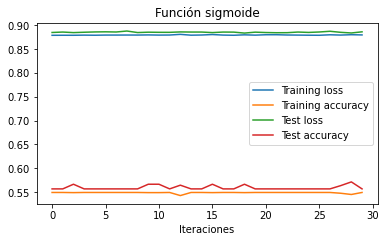

In [25]:
resultados = testEpochs(30)
graficar(range(30), resultados, "Función sigmoide")

### Conclusión de este primer acercamiento
Parece que el primer acercamiento tuvo certeza en al rededor del 55% de los casos.